# Learning Log Heat Kernel

In [1]:
#Modulees

#jax
from jax import jacfwd, vmap
import jax.numpy as jnp
import jax.random as jrandom

#haiku
import haiku as hk

#os
import os

#numpy
import numpy as np

#matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

#other modules
from load_manifold import get_generator_dim, load_manifold

#scores
from models import models

#jaxgeometry
from jaxgeometry.statistics.score_matching import model_loader
from jaxgeometry.autodiff import jacfwdx
from jaxgeometry.statistics.score_matching import MLGeodesicRegression
from jaxgeometry.statistics.score_matching import ScoreEvaluation
from jaxgeometry.manifolds import *

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
2024-05-07 19:33:35.778977: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
plt.rcParams.update({'font.size': 20})
cbformat = tkr.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2)) 

In [3]:
#Hyper Parameters
T = 0.5
score_path = "scores"
s2_approx = 0
s1loss_type = "dsm"
seed = 2712

figure_path = '../figures/learning_log_p/'
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

In [4]:
def get_coords(M, Fx):
    chart = M.centered_chart(Fx)
    return (M.invF((Fx,chart)),chart)

In [5]:
def load_score_model(manifold, dim, method="Local"):
    M, x0, sampling_method, generator_dim, layers, opt_val = load_manifold(manifold, dim)
    if "Local" in sampling_method:
        method = "Local"
    else:
        method = "Embedded"
    
    s1p_path = ''.join((score_path, f"/{manifold}{dim}/s1p_{s1loss_type}/"))
    layers = get_generator_dim(manifold, generator_dim)[0]

    s1p_model = hk.transform(lambda x: models.MLP_p(dim=generator_dim, layers=layers)(x))
        
    s1p_state = model_loader.load_model(s1p_path)
    
    rng_key = jrandom.PRNGKey(seed)
    
    if method == "Local":
        s1p_fun = lambda x,y,t: s1p_model.apply(s1p_state.params, rng_key, jnp.hstack((x[0],y[0],t)))
    else:
        s1p_fun = lambda x,y,t: s1p_model.apply(s1p_state.params, rng_key, jnp.hstack((M.F(x),M.F(y),t)))
                       
    return M, x0, s1p_fun

## Testing with $\mathbb{R}^{2}$

In [6]:
M, x0, s1p_fun = load_score_model("Euclidean", 2)

using M.Exp for Logarithm


In [7]:
N_points = 1000
min_x = -2.0
max_x = 2.0
x1 = jnp.linspace(min_x, max_x, N_points)
x2 = jnp.linspace(min_x, max_x, N_points)

# Creating the coordinate grid for the unit sphere.
X1_R2, X2_R2 = jnp.meshgrid(x1, x2)
X_heat = jnp.transpose(jnp.concatenate((X1_R2.reshape(1, N_points, N_points), 
                     X2_R2.reshape(1, N_points, N_points))), axes=(1,2,0))

theoretical_grad = lambda y: M.log_hk(x0, (y, jnp.zeros(1)), T)
numerical_grad = lambda y: s1p_fun(x0, (y, jnp.zeros(1)), T)
score_log_p = vmap(lambda x2: vmap(lambda x1: numerical_grad(x1))(x2))(X_heat)
true_log_p = vmap(lambda x2: vmap(lambda x1: theoretical_grad(x1))(x2))(X_heat)

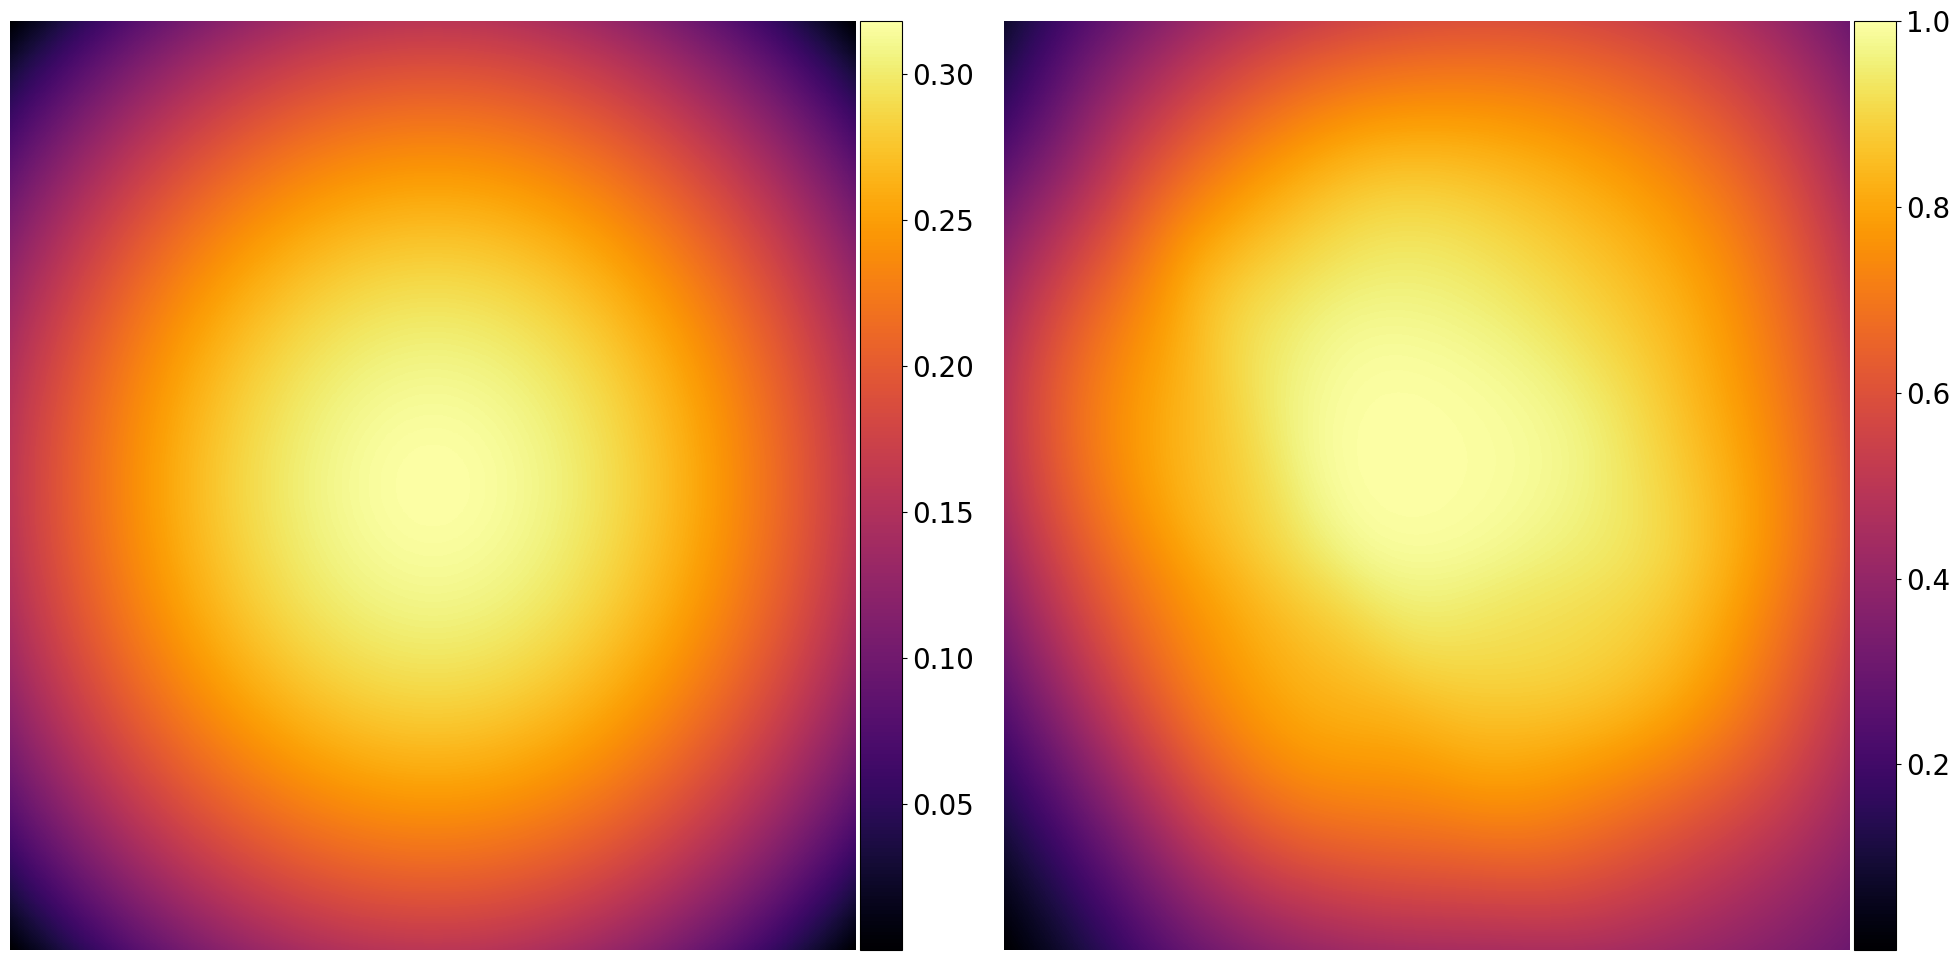

In [8]:
fig = plt.figure(figsize=(20,10))

#R2
plot_log_p = jnp.exp(true_log_p)
ax = fig.add_subplot(121)
ax.imshow(true_log_p, cmap=mpl.cm.inferno, interpolation='nearest', aspect='auto',
          extent=[-2.0,2.0,-2.0,2.0])
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(plot_log_p)
ax.autoscale(False)
ax.set_axis_off()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size='5%', pad=0.05)
fig.colorbar(m, cax=cax, orientation='vertical', format=cbformat)#, cax=cax)

plot_log_p = jnp.exp(score_log_p)
plot_log_p /= jnp.max(plot_log_p)
ax = fig.add_subplot(122)
ax.imshow(score_log_p, cmap=mpl.cm.inferno, interpolation='nearest', aspect='auto',
          extent=[-2.0,2.0,-2.0,2.0])
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(plot_log_p)
ax.autoscale(False)
ax.set_axis_off()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size='5%', pad=0.05)
fig.colorbar(m, cax=cax, orientation='vertical', format=cbformat)#, cax=cax)

fig.tight_layout()

plt.show()

## Testing with $\mathbb{S}^{2}$

In [9]:
M, x0, s1p_fun = load_score_model("Sphere", 2)

using M.Exp for Logarithm


In [10]:
#Plot source: https://stackoverflow.com/questions/44594011/heat-map-on-unit-sphere

# Creating the theta and phi values.

# Creating the theta and phi values.
intervals = 100
ntheta = intervals
nphi = 2*intervals

theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)

# Creating the coordinate grid for the unit sphere.
X1_S2 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2_S2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3_S2 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X_heat = jnp.transpose(jnp.concatenate((X1_S2.reshape(1, ntheta+1, nphi+1), 
                     X2_S2.reshape(1, ntheta+1, nphi+1), 
                     X3_S2.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))

theoretical_grad = lambda y: M.log_hk(x0, get_coords(M,y), T)
numerical_grad = lambda y: s1p_fun(x0, get_coords(M,y), T)
score_log_p = vmap(lambda x2: vmap(lambda x1: numerical_grad(x1))(x2))(X_heat)
true_log_p = vmap(lambda x2: vmap(lambda x1: theoretical_grad(x1))(x2))(X_heat)

In [11]:
true_log_p

Array([[-1.06065338, -1.06065338, -1.06065338, ..., -1.06065338,
        -1.06065338, -1.06065338],
       [-1.06155657, -1.06155657, -1.06155657, ..., -1.06155657,
        -1.06155657, -1.06155657],
       [-1.06426611, -1.06426611, -1.06426611, ..., -1.06426611,
        -1.06426611, -1.06426611],
       ...,
       [-8.50864076, -8.50864076, -8.50864076, ..., -8.50864076,
        -8.50864076, -8.50864076],
       [-8.53329145, -8.53329145, -8.53329145, ..., -8.53329145,
        -8.53329145, -8.53329145],
       [-8.54159228, -8.54159228, -8.54159228, ..., -8.54159228,
        -8.54159228, -8.54159228]], dtype=float64)

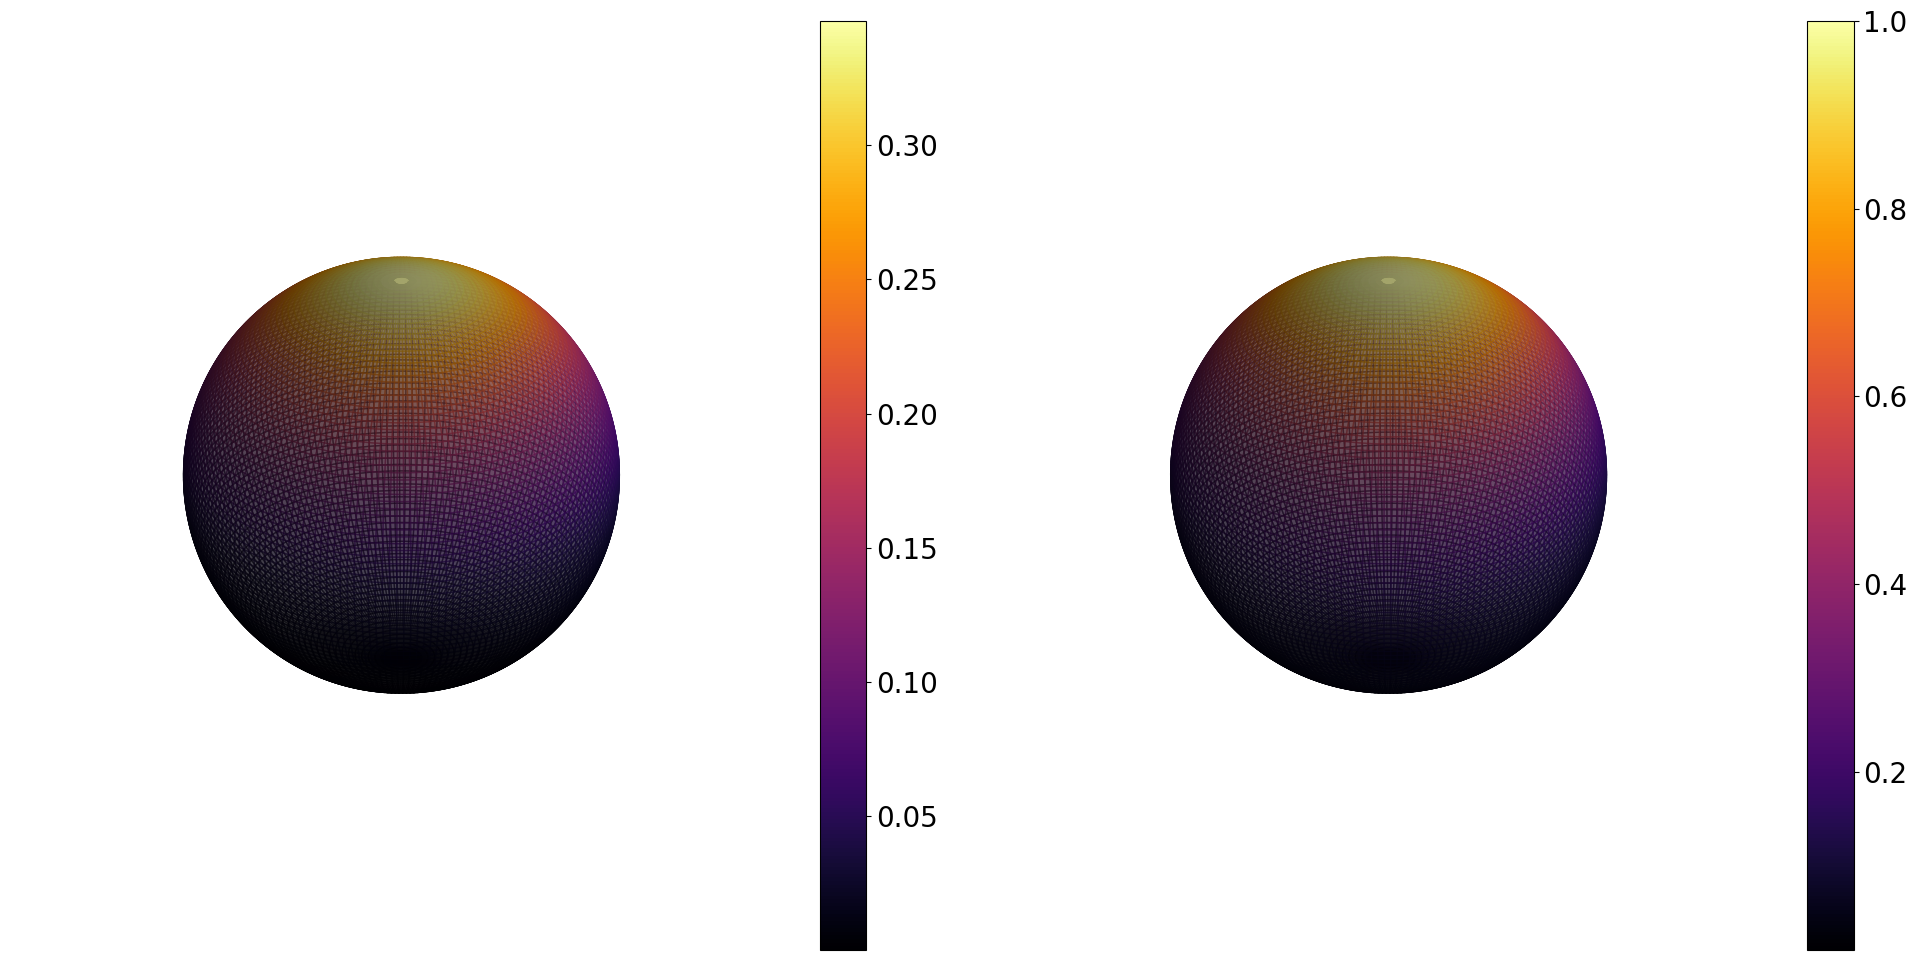

In [12]:
fig = plt.figure(figsize=(20,10))

plot_log_p = jnp.exp(true_log_p)
#S2
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(X1_S2, X2_S2, X3_S2, rstride=1, cstride=1, facecolors=plt.cm.inferno(plot_log_p/jnp.amax(plot_log_p)), alpha=0.5)
ax.set_box_aspect([1,1,1])
ax.autoscale(False)
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(plot_log_p)
divider = make_axes_locatable(ax)
#cax = plt.axes([0.95, 0.12, 0.01, 0.80])
#fig.colorbar(m, cax=cax, format=cbformat)#, cax=cax)
fig.colorbar(m, format=cbformat)

plot_log_p = jnp.exp(score_log_p)
plot_log_p /= jnp.max(plot_log_p)
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X1_S2, X2_S2, X3_S2, rstride=1, cstride=1, facecolors=plt.cm.inferno(plot_log_p/jnp.amax(plot_log_p)), alpha=0.5)
ax.set_box_aspect([1,1,1])
ax.autoscale(False)
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(plot_log_p)
divider = make_axes_locatable(ax)
#cax = plt.axes([0.95, 0.12, 0.01, 0.80])
#fig.colorbar(m, cax=cax, format=cbformat)#, cax=cax)
fig.colorbar(m, format=cbformat)

fig.tight_layout()

plt.show()